<a href="https://colab.research.google.com/github/rtealwitter/fairlyuncertain/blob/main/experiments/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Guided Introduction to FairlyUncertain

In this demo, we will explore some of the functionality of the [FairlyUncertain](https://github.com/rtealwitter/fairlyuncertain) Python package.

In [ ]:
# Roughly 1 minute for installation
! pip install fairlyuncertain

In [2]:
import fairlyuncertain as fu

## Loading Datasets

FairlyUncertain is designed in a modular way to enable easy loading of popular fairness datasets. We can check which datasets are available by inspecting the `dataloaders` dictionary.

In [3]:
# The available datasets
list(fu.dataloaders.keys())

['Adult',
 'Bank',
 'COMPAS',
 'German',
 'MEPS',
 'Law School',
 'Communities',
 'Insurance',
 'IHDP',
 'Twins',
 'ACS']

Let's select the Adult dataset. We can load each dataset by calling the `load_instance` function.

In [4]:
instance = fu.load_instance('Adult')

Caching Adult dataset...


An instance is a standardized object used for training. It includes the number of observations `n`, the covariates `X`, the outcomes `y`, and the group indicator `group`. For standardized comparison, it includes a testing-training split (the ratio can be specified as an optional parameter to `load_instance`) on the data. There are also model hyperparameters specified in the instance.

In [5]:
print(f"The {instance['name']} dataset has {instance['n']} observations with {instance['X'].shape[1]} covariates.")

The Adult dataset has 45222 observations with 102 covariates.


## Using Model

The foundation of FairlyUncertain is a standardized set of algorithms. Each algorithm accepts the `instance` object and outputs a dictionary with predictions in `pred` and, if relevant to the algorithm, an uncertainty estimate in `std`. We can check which algorithms are available by inspecting the `algorithms` dictionary. (Please see the paper for descriptions of each algorithm.)

In [6]:
list(fu.algorithms.keys())

['True',
 'Baseline',
 'Random',
 'Ensemble',
 'Selective Ensemble',
 'Self-(in)consistency',
 'Binomial NLL',
 'Normal NLL',
 '$\\beta$-NLL',
 'Faithful NLL',
 'Threshold Optimizer SP',
 'Threshold Optimizer EO',
 'Exponentiated Gradient SP',
 'Exponentiated Gradient EO',
 'Exponentiated Gradient Square',
 'Exponentiated Gradient Absolute',
 'Grid Search SP',
 'Grid Search EO',
 'Grid Search Square',
 'Grid Search Absolute']

Let's select the Ensemble algorithm.

In [7]:
algorithm = fu.algorithms['Ensemble']
output = algorithm(instance)

The output of the algorithm is a set of predictions and heteroscedastic uncertainty estimates.

In [8]:
output

{'pred': array([0.01725876, 0.5879601 , 0.31332615, ..., 0.72311276, 0.04574106,
        0.01620598], dtype=float32),
 'std': array([0.00260234, 0.02367161, 0.05317773, ..., 0.0178168 , 0.00450354,
        0.00350027], dtype=float32)}

Now that we know how to load a dataset and algorithm, let's consider a set of algorithms evaluated on different datasets.

In [9]:
# Several binary algorithms that output uncertainty estimates
algo_names = ['Ensemble', 'Selective Ensemble', 'Self-(in)consistency', 'Binomial NLL']
# Several binary datasets
datasets = ['Adult', 'Bank', 'COMPAS', 'German']
is_binary = True # Flag for later evaluation

results = {}
for dataset in datasets: # Roughly 15 seconds per dataset
  instance = fu.load_instance(dataset)
  # Instance contains a random testing-training split so we save it for later evaluation
  results[dataset] = {'instance' : instance}
  for algo_name in algo_names:
    algorithm = fu.algorithms[algo_name]
    output = algorithm(instance)
    results[dataset][algo_name] = output


Caching Bank dataset...
Caching COMPAS dataset...
Caching German dataset...


## Visualizing Calibration

We can visualize the calibration of the algorithms by calling `plot_calibration`. For groups of observations with similar uncertainty estimates, the plot shows the average empirical standard deviation against the average predicted uncertainty.

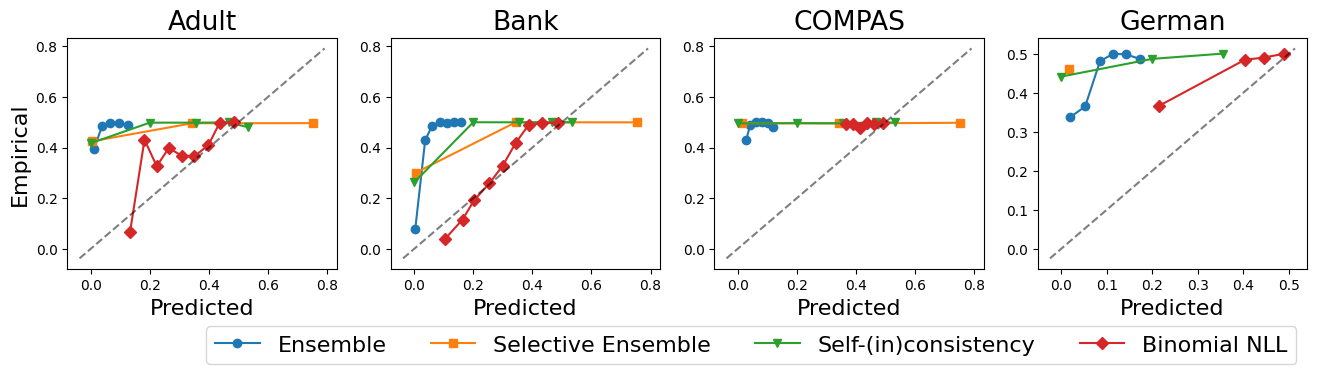

In [10]:
fu.plot_calibration(results, is_binary, algo_names, datasets)

The dashed gray line indicates the perfectly calibrated model. While not perfect, Binomial NLL is closest to calibrated.

## Measuring Calibration

We can also measure calibration by computing the Negative Log-Likelihood (NLL) for each algorithm.

In [11]:
nll_results = {}

for dataset in datasets:
  instance = results[dataset]['instance']
  nll_results[dataset] = {}
  for algo_name in algo_names:
    output = results[dataset][algo_name]
    nll = fu.get_nll(output['pred'], output['std'], instance['y_test'], is_binary)
    nll_results[dataset][algo_name] = nll


fu.print_table(nll_results, output_latex=False, include_var=False)

Approach                Adult    Bank    COMPAS    German
--------------------  -------  ------  --------  --------
Ensemble                0.891   0.45      1.85      1.25
Selective Ensemble      0.858   0.442     1.87      1.45
Self-(in)consistency    0.804   0.381     1.6       1.2
Binomial NLL            0.308   0.191     0.601     0.574


As suggested by the plots, Binomial NLL is the most calibrated model as measured by NLL.

## Binary Fairness with Abstention

We can evaluate the fairness of each algorithm using several standard fairness metrics. In order to incorporate uncertainty, we'll use the abstention framework where models have the option to abstain from predictions with high predicted uncertainty. We'll compare the fairness of models in the abstention framework to standard fairness interventions.

In [12]:
dataset = 'ACS' # Select a binary dataset

instance = fu.load_instance(dataset)

algo_names += [
    'Baseline', # No fairness intervention
    'Exponentiated Gradient EO', # Fairness intervention to minimize equalized odds
    'Exponentiated Gradient SP', # Fairness intervention to minimize statistical parity
]

num_runs = 5
results = {}
for num_run in range(num_runs): # Roughly 1 minutes per loop
  results[num_run] = {'instance' : instance}
  for algo_name in algo_names:
    algorithm = fu.algorithms[algo_name]
    output = algorithm(instance)
    results[num_run][algo_name] = output

Caching ACS dataset...


We can print a table to easily inspect the fairness performance below.

In [13]:
metric_values = fu.compute_binary_fairness(results, algo_names, fu.binary_metrics)

fu.print_table(metric_values, output_latex=False, include_var=False)

Approach                     Error Rate    Statistical Parity    Equalized Odds    Included \%
-------------------------  ------------  --------------------  ----------------  -------------
Ensemble                          0.134                 0.056             0.033           85
Selective Ensemble                0.153                 0.076             0.035           97
Self-(in)consistency              0.15                  0.075             0.033           96.2
Binomial NLL                      0.105                 0.091             0.028           75
Baseline                          0.159                 0.068             0.035          100
Exponentiated Gradient EO         0.163                 0.081             0.045          100
Exponentiated Gradient SP         0.17                  0.033             0.037          100
